# null hypothesis: There is no difference in similarities of documents analyzed through by Doc2Vec and Word2Vec
# alternate hypothesis: There are differences in similarities of documents  analyzed through Doc2Vec and Word2Vec

In [321]:
import pandas as pd

In [322]:
from gensim.models import doc2vec
from gensim.models import word2vec

In [323]:
def label_sentence(sentence, label):
    return doc2vec.LabeledSentence(words=sentence, tags=[label])

In [324]:
df = pd.read_csv("./billboard.csv",encoding="latin")

In [325]:
df = df.dropna()
df = df[df['Lyrics']!="instrumental"]

In [326]:
df.drop('Rank',axis=1)
df = df.reset_index(drop=True)

# Preparing Labelled Sentences for training Doc2Vec

In [327]:
docs = []
for i in range(len(df)):
    row = df.iloc[i]
    lyrics = row['Lyrics']
    if(lyrics != "instrumental"):
        docs.append(label_sentence(lyrics,str(i)))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  


# Training Doc2Vec and Word2Vec on same set of Lyrics (Billboard songs 1965 - 2015)

In [328]:
d2v = doc2vec.Doc2Vec(docs, size=300, window=8, min_count=5, workers=4)
w2v = word2vec.Word2Vec(df['Lyrics'].apply(lambda x:x.split(" ")), size=300, window= 8, min_count=5,workers=4)

/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:366: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [406]:
d2v_sim = [None]*len(df)
for i,d in d2v.docvecs.most_similar("2178",topn=len(df)):
    d2v_sim[int(i)] = d

# Adding Doc2Vec similarity of Rick Roll lyrics to lyrics of all other songs to data frame column 

In [332]:
df['d2v_similarity']=d2v_sim

In [330]:
def getWord2VecSentenceVector(sentence):
    sentence = sentence.split(" ")
    vector = None
    i = 0
    for word in sentence:
        try:
            v = w2v[word]
            if(vector is None):
                vector = v
                i+=1
            else:
                vector =vector+v
        except:
            continue
    vector /= i
    return vector

# Adding Word2Vec similarity of Rick Roll lyrics to lyrics of all other songs to data frame column 

In [331]:
df['w2v_vector'] = df['Lyrics'].apply(getWord2VecSentenceVector)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [335]:
from scipy.spatial.distance import cosine
rick_roll = getWord2VecSentenceVector(df.iloc[2178]['Lyrics'])
df['w2v_similarity'] = df['w2v_vector'].apply(lambda x:cosine(x,rick_roll))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [353]:
import matplotlib.pyplot as plt

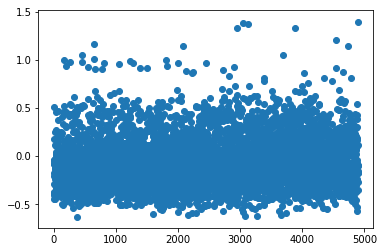

In [355]:
plt.scatter(range(len(df)),df['w2v_similarity']-df['d2v_similarity'])

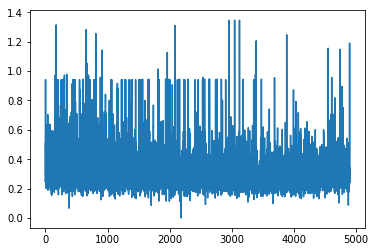

In [360]:
plt.plot(df['w2v_similarity'])


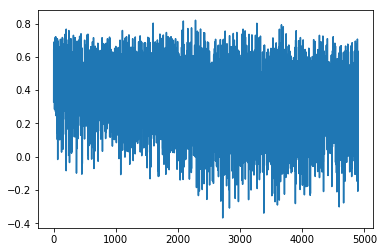

In [361]:
plt.plot(df['d2v_similarity'])

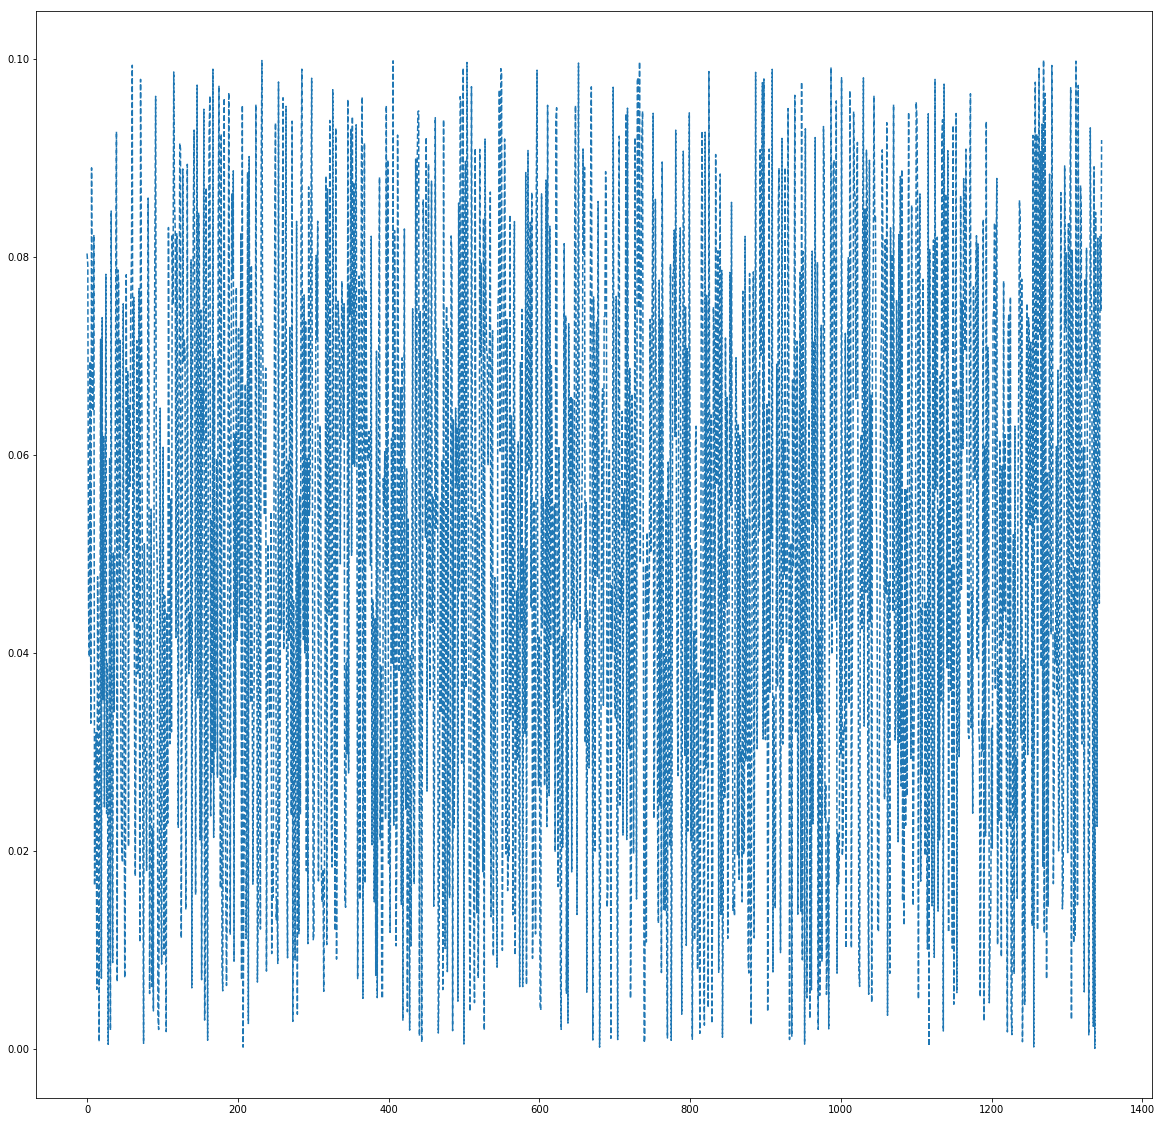

In [379]:
plt.figure(figsize=(20,20))
# plt.plot(df['d2v_similarity'])
# plt.plot(df['w2v_similarity'])
plt.plot([x for x in (df['d2v_similarity']-df['w2v_similarity']).apply(lambda x:abs(x)) if x <= 0.1],linestyle='--')

# Finding number of songs where Doc2Vec and Word2Vec share cosine similarity within 10% range

In [388]:
len([x for x in (df['d2v_similarity']-df['w2v_similarity']).apply(lambda x:abs(x)) if x <= 0.1])

1347

In [386]:
len(df)

4898

In [404]:
1347/4898

0.2750102082482646

In [389]:
from annoy import AnnoyIndex

In [393]:
w2v_cluster = AnnoyIndex(300,metric='angular')

In [394]:
for i in range(len(df)):
    row = df.iloc[i]
    vector = row['w2v_vector']
    w2v_cluster.add_item(i,vector)

In [395]:
w2v_cluster.build(100)

True

# showing top 10 most similar songs to Rick Roll using Word2Vec

In [398]:
for i in w2v_cluster.get_nns_by_vector(rick_roll,10):
    print(df.iloc[i]['Song'])
    print()
    print(df.iloc[i]['Lyrics'])
    print()

never gonna give you up

 ooh oohwere no strangers to love you know the rules and so do i a full commitments what im thinking of you wouldnt get this from any other guy i just wanna tell you how im feeling gotta make you understandnever gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt youweve known each other for so long your hearts been aching but youre too shy to say it inside we both know whats been going on we know the game and were gonna play it and if you ask me how im feeling dont tell me youre too blind to seenever gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt younever gonna give you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt youooh give you up ooh gi

# showing top 10 most similar songs to Rick Roll using Doc2Vec

In [403]:
for i,d in d2v.docvecs.most_similar("2178",topn=10):
    print(df.iloc[int(i)]['Song'])
    print()
    print(df.iloc[int(i)]['Lyrics'])
    print()

baby i love your wayfreebird medley

 shadows grow so long before my eyes and theyre moving across the page suddenly the day turns into night far away from the citybut dont hesitate cause your love your love wont wait hononoooh baby i love your way every day ooh wanna tell you i love your way every day ooh wanna be with you night and dayhey yeah i love your wayif i leave here tomorrow will you still remember me for i must be traveling on now theres so many places i gotta seebut if i stayed here with you girl things just wouldnt be the same cause im as free as a bird now and this bird will never change and this bird will never changeshadows grow so long before my eyes with the help of some fireflies i wonder how they have the power to shine i can see them under the pinesbut dont hesitate cause your love wont waitooh baby i love your way ooh wanna tell you i love your way ooh baby i love your way every day now ooh wanna tell you i love your way i love your way ooh baby i love your way gi